<a href="https://colab.research.google.com/github/MisakaTemple/assignment666/blob/main/Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import SplineTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from prophet import Prophet

In [ ]:
# Load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
data = pd.read_csv(url)


# Convert the date column to datetime object
data['Date'] = pd.to_datetime(data['Date'])

# Set the date column as index
data.set_index('Date', inplace=True)

# Ensure the index has the relevant frequency information
data = data.asfreq('D')

# Create a new column, representing the day of the year
data['day_of_year'] = data.index.dayofyear

# Split the dataset into training and testing sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size].copy(), data[train_size:].copy()

# Use forward fill to handle NaN values
train.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)

# If the first value is NaN, use backward fill
train.fillna(method='bfill', inplace=True)
test.fillna(method='bfill', inplace=True)

# Define input features and target variable
X_train, y_train = train['day_of_year'].values.reshape(-1, 1), train['Temp']
X_test, y_test = test['day_of_year'].values.reshape(-1, 1), test['Temp']

# Create SplineTransformer instance
spline_transformer = SplineTransformer(n_knots=12, degree=3)  # Here we chose 12 knots and 3rd degree spline

# Fit SplineTransformer and transform input features
X_train_transformed = spline_transformer.fit_transform(X_train)
X_test_transformed = spline_transformer.transform(X_test)

Number of rows: 3650
Number of columns: 2


In [ ]:
# LinearRegression
lr = LinearRegression()
lr.fit(X_train_transformed, y_train)
y_pred_lr = lr.predict(X_test_transformed)
mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f'Linear Regression Mean Squared Error: {mse_lr}')

# SVR
svr = SVR(kernel='rbf', C=1, gamma='auto', epsilon=0.1)
svr.fit(X_train_transformed, y_train)
y_pred_svr = svr.predict(X_test_transformed)
mse_svr = mean_squared_error(y_test, y_pred_svr)
print(f'Support Vector Regression Mean Squared Error: {mse_svr}')

# MLP
mlp = MLPRegressor(max_iter=1000, random_state=42)
mlp.fit(X_train_transformed, y_train)
y_pred_mlp = mlp.predict(X_test_transformed)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
print(f'Neural Network Mean Squared Error: {mse_mlp}')

# Prophet
train_prophet = train.reset_index().rename(columns={'Date':'ds', 'Temp':'y'})
test_prophet = test.reset_index().rename(columns={'Date':'ds', 'Temp':'y'})
model_prophet = Prophet(yearly_seasonality=True, daily_seasonality=True, seasonality_mode='multiplicative')
model_prophet.fit(train_prophet)
future = model_prophet.make_future_dataframe(periods=len(y_test))
forecast_prophet = model_prophet.predict(future)
y_pred_prophet = forecast_prophet['yhat'][len(y_train):]
mse_prophet = mean_squared_error(y_test, y_pred_prophet)
print(f'Prophet Mean Squared Error: {mse_prophet}')

Linear Regression Mean Squared Error: 6.520168556808283
Support Vector Regression Mean Squared Error: 7.075730295670725
Neural Network Mean Squared Error: 6.516288593478761


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyyv90kzl/y7pk4u_p.json


ARIMA Mean Squared Error: 27.802571170102006


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyyv90kzl/dwarztdz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64638', 'data', 'file=/tmp/tmpyyv90kzl/y7pk4u_p.json', 'init=/tmp/tmpyyv90kzl/dwarztdz.json', 'output', 'file=/tmp/tmpyyv90kzl/prophet_modeloguhgl_7/prophet_model-20231017185305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Mean Squared Error: 9.471294402697966


In [ ]:
# Calculate other evaluation metrics
r2_lr = r2_score(y_test, y_pred_lr)
r2_svr = r2_score(y_test, y_pred_svr)
r2_mlp = r2_score(y_test, y_pred_mlp)
r2_prophet = r2_score(y_test, y_pred_prophet)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
mae_prophet = mean_absolute_error(y_test, y_pred_prophet)

# Print evaluation results
print(f'Linear Regression R-squared: {r2_lr}, MAE: {mae_lr}')
print(f'Support Vector Regression R-squared: {r2_svr}, MAE: {mae_svr}')
print(f'Neural Network R-squared: {r2_mlp}, MAE: {mae_mlp}')
print(f'Prophet R-squared: {r2_prophet}, MAE: {mae_prophet}')

Linear Regression R-squared: 0.6125656217087658, MAE: 1.9926652274281806
Support Vector Regression R-squared: 0.5795536351284785, MAE: 2.062328932340333
Neural Network R-squared: 0.6127961726780038, MAE: 1.9904811460618366
ARIMA R-squared: -0.6520542041721618, MAE: 4.316195930299916
Prophet R-squared: 0.4372070251633482, MAE: 2.511106778829246


In [ ]:
import pandas as pd

# Create empty DataFrame
model_comparison = pd.DataFrame(columns=['Model', 'Mean Squared Error', 'R-squared', 'Mean Absolute Error'])

# Add model evaluation metrics
model_comparison.loc[0] = ['Linear Regression', mse_lr, r2_lr, mae_lr]
model_comparison.loc[1] = ['Support Vector Regression', mse_svr, r2_svr, mae_svr]
model_comparison.loc[2] = ['Neural Network', mse_mlp, r2_mlp, mae_mlp]
model_comparison.loc[3] = ['Prophet', mse_prophet, r2_prophet, mae_prophet]

# Print the form
print(model_comparison)

                       Model  Mean Squared Error  R-squared  \
0          Linear Regression            6.520169   0.612566   
1  Support Vector Regression            7.075730   0.579554   
2             Neural Network            6.516289   0.612796   
3                    Prophet            9.471294   0.437207   

   Mean Absolute Error  
0             1.992665  
1             2.062329  
2             1.990481  
3             2.511107  


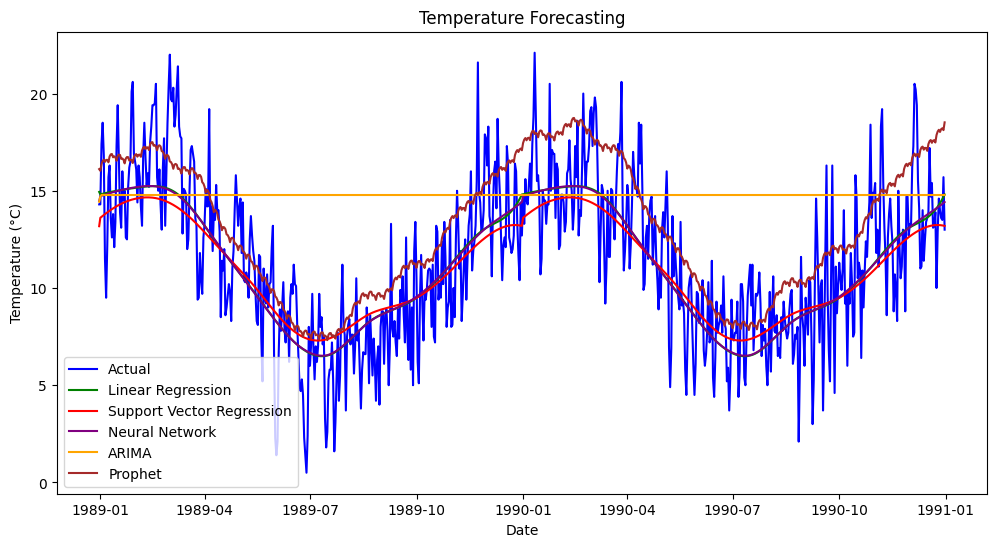

In [ ]:
# Plot actual values and predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual', color='blue')
plt.plot(test.index, y_pred_lr, label='Linear Regression', color='green')
plt.plot(test.index, y_pred_svr, label='Support Vector Regression', color='red')
plt.plot(test.index, y_pred_mlp, label='Neural Network', color='purple')
plt.plot(test.index, y_pred_prophet, label='Prophet', color='brown')

# Add title and labels
plt.title('Temperature Forecasting')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')

# Add legend
plt.legend()

# Display the plot
plt.show()